# Where are the cycles?

Sources:
- https://www.youtube.com/watch?v=SDoIbFuKgfU
- https://stooq.com/q/d/?s=^spx

In [135]:
%matplotlib inline
from matplotlib.pyplot import *

import numpy as np
import scipy as sp
import pandas as pd

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [180]:
data = pd.read_csv("prices.csv")
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.resample(
    'A',
    how={
        'Close': 'last',
    },
)

prices = data.Close.values

data['returns'] = np.nan
data.iloc[1:, list(data.columns).index('returns')] = (prices[1:] - prices[:-1]) / prices[:-1]

data['mv'] = data.returns.rolling(10).mean()

/Users/dradrian/.virtualenvs/economicallywoke/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  import sys


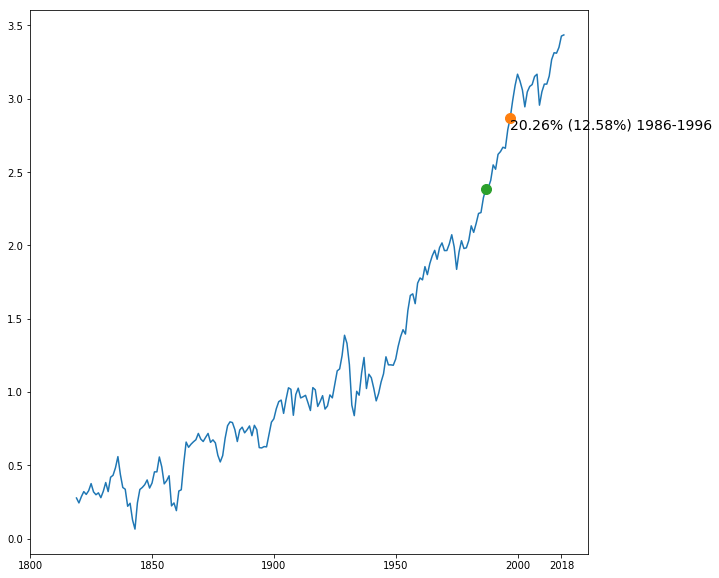

In [201]:
sub = data.dropna()
sub = sub[sub.index >= '1818-01-01']

figure(figsize=(10, 10))

plot(np.log10(sub.Close))

ax = gca()



point = data.loc['1996-12-31'].to_dict()
plot(datetime(1996, 12, 31), np.log10(point['Close']), '.', markersize=20)

ax.text(
    datetime(1996, 12, 31),
    np.log10(point['Close']),
    "{:0.2%} ({:0.2%}) 1986-1996".format(point['returns'], point['mv']),
    transform=ax.transData,
    fontsize=14,
    verticalalignment='top',
    bbox=dict(edgecolor='none', facecolor='none'),
)



point2 = data.loc['1986-12-31'].to_dict()
plot(datetime(1986, 12, 31), np.log10(point2['Close']), '.', markersize=20)

# ax.text(
#     datetime(1996, 12, 31),
#     np.log10(point['Close']),
#     "{:0.2%}".format(point['returns']),
#     transform=ax.transData,
#     fontsize=14,
#     verticalalignment='top',
#     bbox=dict(edgecolor='none', facecolor='none'),
# )



xticks([
    datetime(1800, 1, 1),
    datetime(1850, 1, 1),
    datetime(1900, 1, 1),
    datetime(1950, 1, 1),
    datetime(2000, 1, 1),
    datetime(2018, 1, 1),
]);

savefig('example.svg')

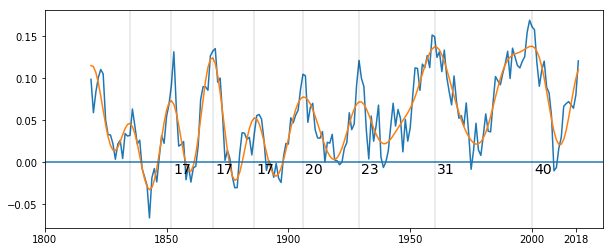

In [177]:
sub = data.dropna()
sub = sub[sub.index >= '1818-01-01']

cycle = sub.mv.values
F = np.fft.fft(cycle)
F[np.abs(F) < 1] = 0
fcycle = np.fft.ifft(F)
sub['fcycle'] = np.real(fcycle)

sub['directions'] = np.nan
sub.iloc[1:, list(sub.columns).index('directions')] = np.sign(np.diff(sub.fcycle.values))

sub['turning_points'] = np.nan
sub.iloc[2:, list(sub.columns).index('turning_points')] = np.sign(np.diff(np.sign(np.diff(sub.fcycle.values))))

# Get the dates of the peaks
peaks = sub.reset_index().Date[sub.turning_points.values == -1].dt.to_pydatetime()


figure(figsize=(10, 4))
plot(sub.mv)
plot(sub.fcycle)
axhline(0)


ax = gca()


for peak in peaks:
    ax.axvline(peak - relativedelta(years=1), color='k', alpha=0.1)
    
for peak, delta in zip(peaks[1:], np.diff(peaks)):

    ax.text(
        peak,
        0,
        "{:0.0f}".format(delta.days / 365.0),
        transform=ax.transData,
        fontsize=14,
        verticalalignment='top',
        bbox=dict(edgecolor='none', facecolor='none'),
    )
    
    
xticks([
    datetime(1800, 1, 1),
    datetime(1850, 1, 1),
    datetime(1900, 1, 1),
    datetime(1950, 1, 1),
    datetime(2000, 1, 1),
    datetime(2018, 1, 1),
])

savefig('cycles.svg')